In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("course_lead_scoring2.csv")

In [4]:
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())

# Data preparation - Handle missing values
print("\n" + "="*50)
print("DATA PREPARATION")
print("="*50)

# Identify categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove target variable from the lists if present
if 'converted' in categorical_cols:
    categorical_cols.remove('converted')
if 'converted' in numerical_cols:
    numerical_cols.remove('converted')

print(f"\nCategorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

# Fill missing values
for col in categorical_cols:
    df[col] = df[col].fillna('NA')

for col in numerical_cols:
    df[col] = df[col].fillna(0.0)

print("\nMissing values after filling:")
print(df.isnull().sum())

# Split the data: 60% train, 20% validation, 20% test
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)  # 0.25 * 0.8 = 0.2

print(f"\nTrain size: {len(df_train)} ({len(df_train)/len(df)*100:.1f}%)")
print(f"Validation size: {len(df_val)} ({len(df_val)/len(df)*100:.1f}%)")
print(f"Test size: {len(df_test)} ({len(df_test)/len(df)*100:.1f}%)")

y_train = df_train['converted'].values
y_val = df_val['converted'].values
y_test = df_test['converted'].values

print("\n" + "="*50)
print("QUESTION 1: ROC AUC FEATURE IMPORTANCE")
print("="*50)

Dataset shape: (1462, 9)

First few rows:
    lead_source    industry  number_of_courses_viewed  annual_income  \
0      paid_ads         NaN                         1        79450.0   
1  social_media      retail                         1        46992.0   
2        events  healthcare                         5        78796.0   
3      paid_ads      retail                         2        83843.0   
4      referral   education                         3        85012.0   

  employment_status       location  interaction_count  lead_score  converted  
0        unemployed  south_america                  4        0.94          1  
1          employed  south_america                  1        0.80          0  
2        unemployed      australia                  3        0.69          1  
3               NaN      australia                  1        0.87          0  
4     self_employed         europe                  3        0.62          1  

Data types:
lead_source                  object
in

In [5]:
# Question 1: ROC AUC for numerical features
numerical_features = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']

auc_scores = {}
for feature in numerical_features:
    score = df_train[feature].values
    auc = roc_auc_score(y_train, score)
    
    # If AUC < 0.5, invert the variable
    if auc < 0.5:
        auc = roc_auc_score(y_train, -score)
        print(f"{feature}: AUC = {auc:.4f} (inverted)")
    else:
        print(f"{feature}: AUC = {auc:.4f}")
    
    auc_scores[feature] = auc

best_feature = max(auc_scores, key=auc_scores.get)
print(f"\nAnswer Q1: {best_feature} has the highest AUC = {auc_scores[best_feature]:.4f}")

print("\n" + "="*50)
print("QUESTION 2: TRAINING THE MODEL")
print("="*50)

lead_score: AUC = 0.6145
number_of_courses_viewed: AUC = 0.7636
interaction_count: AUC = 0.7383
annual_income: AUC = 0.5520

Answer Q1: number_of_courses_viewed has the highest AUC = 0.7636

QUESTION 2: TRAINING THE MODEL


In [6]:
# Question 2: Train logistic regression
# Prepare features (exclude target)
train_dict = df_train.drop('converted', axis=1).to_dict(orient='records')
val_dict = df_val.drop('converted', axis=1).to_dict(orient='records')

# One-hot encoding
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

# Train logistic regression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Evaluate on validation set
y_pred_val = model.predict_proba(X_val)[:, 1]
auc_val = roc_auc_score(y_val, y_pred_val)

print(f"AUC on validation dataset: {auc_val:.3f}")
print(f"\nAnswer Q2: {auc_val:.3f}")

print("\n" + "="*50)
print("QUESTION 3: PRECISION AND RECALL")
print("="*50)

AUC on validation dataset: 0.817

Answer Q2: 0.817

QUESTION 3: PRECISION AND RECALL


Plot saved as 'precision_recall_plot.png'

Precision and Recall intersect at threshold: 0.980
Answer Q3: 0.980

QUESTION 4: F1 SCORE


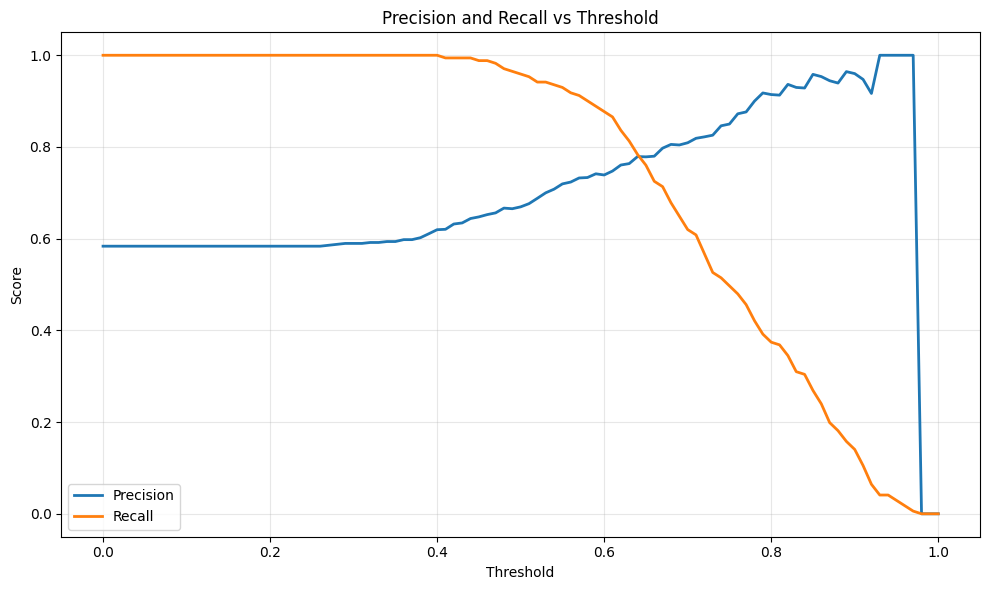

In [7]:
# Question 3: Precision and Recall at different thresholds
thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []

for threshold in thresholds:
    y_pred_binary = (y_pred_val >= threshold).astype(int)
    
    # Calculate precision and recall
    tp = np.sum((y_pred_binary == 1) & (y_val == 1))
    fp = np.sum((y_pred_binary == 1) & (y_val == 0))
    fn = np.sum((y_pred_binary == 0) & (y_val == 1))
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    precisions.append(precision)
    recalls.append(recall)

# Plot precision and recall
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', linewidth=2)
plt.plot(thresholds, recalls, label='Recall', linewidth=2)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('precision_recall_plot.png', dpi=300, bbox_inches='tight')
print("Plot saved as 'precision_recall_plot.png'")

# Find intersection point
min_diff = float('inf')
intersection_threshold = 0.0

for i, threshold in enumerate(thresholds):
    diff = abs(precisions[i] - recalls[i])
    if diff < min_diff:
        min_diff = diff
        intersection_threshold = threshold

print(f"\nPrecision and Recall intersect at threshold: {intersection_threshold:.3f}")
print(f"Answer Q3: {intersection_threshold:.3f}")

print("\n" + "="*50)
print("QUESTION 4: F1 SCORE")
print("="*50)


Maximum F1 score: 0.8125 at threshold: 0.57
Answer Q4: 0.57
Plot saved as 'f1_score_plot.png'

QUESTION 5: 5-FOLD CROSS VALIDATION


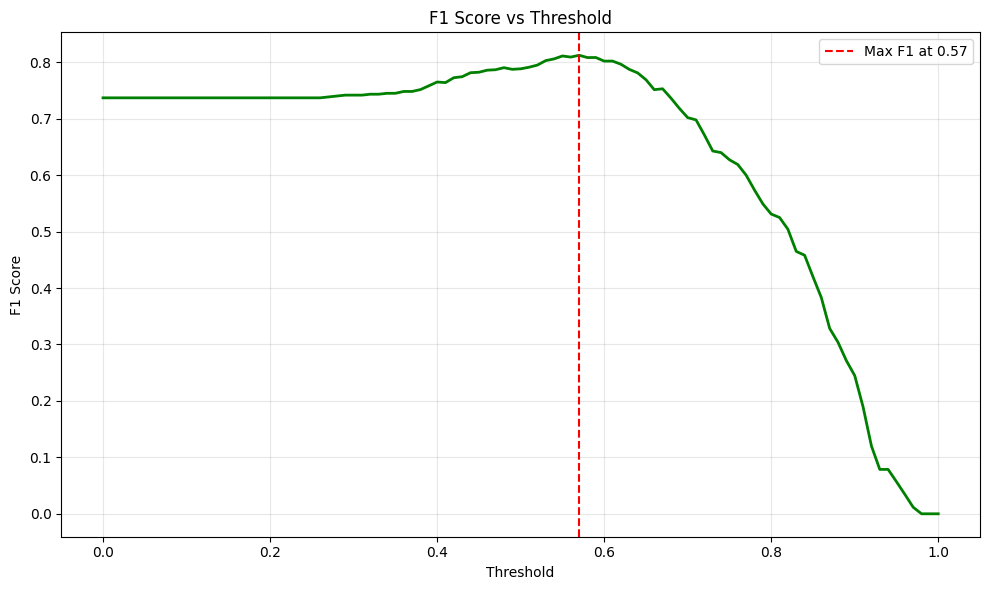

In [8]:
# Question 4: F1 Score
f1_scores = []

for i, threshold in enumerate(thresholds):
    p = precisions[i]
    r = recalls[i]
    
    if (p + r) > 0:
        f1 = 2 * p * r / (p + r)
    else:
        f1 = 0
    
    f1_scores.append(f1)

# Find maximum F1 score
max_f1_idx = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_idx]
max_f1_value = f1_scores[max_f1_idx]

print(f"Maximum F1 score: {max_f1_value:.4f} at threshold: {max_f1_threshold:.2f}")
print(f"Answer Q4: {max_f1_threshold:.2f}")

# Plot F1 score
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, linewidth=2, color='green')
plt.axvline(x=max_f1_threshold, color='red', linestyle='--', label=f'Max F1 at {max_f1_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('f1_score_plot.png', dpi=300, bbox_inches='tight')
print("Plot saved as 'f1_score_plot.png'")

print("\n" + "="*50)
print("QUESTION 5: 5-FOLD CROSS VALIDATION")
print("="*50)

In [9]:
# Question 5: 5-Fold CV
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

cv_scores = []

for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(df_full_train)):
    # Split data
    df_train_fold = df_full_train.iloc[train_idx]
    df_val_fold = df_full_train.iloc[val_idx]
    
    y_train_fold = df_train_fold['converted'].values
    y_val_fold = df_val_fold['converted'].values
    
    # Prepare features
    train_dict_fold = df_train_fold.drop('converted', axis=1).to_dict(orient='records')
    val_dict_fold = df_val_fold.drop('converted', axis=1).to_dict(orient='records')
    
    # One-hot encoding
    dv_fold = DictVectorizer(sparse=False)
    X_train_fold = dv_fold.fit_transform(train_dict_fold)
    X_val_fold = dv_fold.transform(val_dict_fold)
    
    # Train model
    model_fold = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model_fold.fit(X_train_fold, y_train_fold)
    
    # Evaluate
    y_pred_fold = model_fold.predict_proba(X_val_fold)[:, 1]
    auc_fold = roc_auc_score(y_val_fold, y_pred_fold)
    cv_scores.append(auc_fold)
    
    print(f"Fold {fold_idx + 1}: AUC = {auc_fold:.4f}")

mean_auc = np.mean(cv_scores)
std_auc = np.std(cv_scores)

print(f"\nMean AUC: {mean_auc:.4f}")
print(f"Standard Deviation: {std_auc:.4f}")
print(f"Answer Q5: {std_auc:.4f}")

print("\n" + "="*50)
print("QUESTION 6: HYPERPARAMETER TUNING")
print("="*50)


Fold 1: AUC = 0.8061
Fold 2: AUC = 0.8714
Fold 3: AUC = 0.7754
Fold 4: AUC = 0.8018
Fold 5: AUC = 0.8558

Mean AUC: 0.8221
Standard Deviation: 0.0358
Answer Q5: 0.0358

QUESTION 6: HYPERPARAMETER TUNING


In [10]:
# Question 6: Hyperparameter tuning
C_values = [0.000001, 0.001, 1]
results = []

for C in C_values:
    print(f"\nTesting C = {C}")
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    fold_scores = []
    
    for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(df_full_train)):
        # Split data
        df_train_fold = df_full_train.iloc[train_idx]
        df_val_fold = df_full_train.iloc[val_idx]
        
        y_train_fold = df_train_fold['converted'].values
        y_val_fold = df_val_fold['converted'].values
        
        # Prepare features
        train_dict_fold = df_train_fold.drop('converted', axis=1).to_dict(orient='records')
        val_dict_fold = df_val_fold.drop('converted', axis=1).to_dict(orient='records')
        
        # One-hot encoding
        dv_fold = DictVectorizer(sparse=False)
        X_train_fold = dv_fold.fit_transform(train_dict_fold)
        X_val_fold = dv_fold.transform(val_dict_fold)
        
        # Train model
        model_fold = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model_fold.fit(X_train_fold, y_train_fold)
        
        # Evaluate
        y_pred_fold = model_fold.predict_proba(X_val_fold)[:, 1]
        auc_fold = roc_auc_score(y_val_fold, y_pred_fold)
        fold_scores.append(auc_fold)
    
    mean_score = np.mean(fold_scores)
    std_score = np.std(fold_scores)
    
    results.append({
        'C': C,
        'mean': round(mean_score, 3),
        'std': round(std_score, 3)
    })
    
    print(f"  Mean AUC: {mean_score:.3f}")
    print(f"  Std AUC: {std_score:.3f}")

print("\n" + "="*50)
print("SUMMARY OF RESULTS")
print("="*50)

print("\nHyperparameter Tuning Results:")
for result in results:
    print(f"C = {result['C']}: mean = {result['mean']}, std = {result['std']}")

# Find best C
best_result = max(results, key=lambda x: (x['mean'], -x['std'], -x['C']))
print(f"\nAnswer Q6: Best C = {best_result['C']} with mean = {best_result['mean']} and std = {best_result['std']}")

print("\n" + "="*50)
print("ALL ANSWERS SUMMARY")
print("="*50)
print(f"Q1: Feature with highest AUC: {best_feature}")
print(f"Q2: AUC on validation: {auc_val:.3f}")
print(f"Q3: Precision-Recall intersection: {intersection_threshold:.3f}")
print(f"Q4: Threshold with max F1: {max_f1_threshold:.2f}")
print(f"Q5: Std of 5-fold CV scores: {std_auc:.4f}")
print(f"Q6: Best C value: {best_result['C']}")


Testing C = 1e-06
  Mean AUC: 0.560
  Std AUC: 0.024

Testing C = 0.001
  Mean AUC: 0.867
  Std AUC: 0.029

Testing C = 1
  Mean AUC: 0.822
  Std AUC: 0.036

SUMMARY OF RESULTS

Hyperparameter Tuning Results:
C = 1e-06: mean = 0.56, std = 0.024
C = 0.001: mean = 0.867, std = 0.029
C = 1: mean = 0.822, std = 0.036

Answer Q6: Best C = 0.001 with mean = 0.867 and std = 0.029

ALL ANSWERS SUMMARY
Q1: Feature with highest AUC: number_of_courses_viewed
Q2: AUC on validation: 0.817
Q3: Precision-Recall intersection: 0.980
Q4: Threshold with max F1: 0.57
Q5: Std of 5-fold CV scores: 0.0358
Q6: Best C value: 0.001
